##Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Применение предобученной сети для распознавания котов и собак



Домашнее задание:

1 Зарегистрируйтесь на закрытое соревнование на Kaggle по ссылке
https://www.kaggle.com/account/login?ReturnUrl=%2Ft%2Fed48c4911fe848ed92458288f5a76152
2 Используйте шаблон ноутбука, чтобы отправить решение на Kaggle 
https://colab.research.google.com/drive/12GmAc5UpM0TuB1o5uMkih4FO8SVNFfU-
3 Попробуйте изменить нейронную сеть, чтобы улучшить качество решения:
Изменяйте часть сети, отвечающей за классификацию: количество полносвязных слоев и нейронов в них, параметры Dropout и т.п.
Изменяйте размер мини-выборки и количество шагов на каждой эпохе обучения
Изменяйте параметры дополнения данных (документация https://keras.io/preprocessing/image/)
Попробуйте включить тонкую настройку нейронной сети (разморозить несколько слоев VGG16 и дообучить их)
4 Во время обучения следите, чтобы не возникло переобучения
5 После подбора лучших гиперпараметров, обучите сеть еще раз на полном объеме данных без разделения на обучающий и проверочный наборы
 
Дополнительное задание
Замените сеть VGG16 на ResNet, Inception, или любую другую из https://keras.io/applications/
 
7 Составьте отчет, который включает:
Место в соревновании, которое вам удалось достичь
Описание архитектуры нейронной сети и гиперпараметров обучения
Ссылку на ноутбук с кодом обучения
График качества обучения на обучающем и проверочном наборах данных
Ограничение по количеству отправок решений в день – 10 шт
 
Дополнительное задание
Используя новые знания об архитектуре сверточных нейронных сетей, которые вы получили в этом занятии, попытайтесь улучшить свои результаты в соревновании по распознаванию рукописных цифр и объектов Cifar-10

In [0]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.nasnet import NASNetLarge 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.mongoexp import MongoTrials

from sklearn.metrics import accuracy_score

from google.colab import files
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.misc import toimage
import gc
import os
import pickle
import shutil

%matplotlib inline 

##Kaggle

In [0]:
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle
!ls ~/.kaggle

kaggle.json


Загружаем данные с сайта Kaggle

In [0]:
!kaggle competitions download -c nu-cats-and-dogs-spring2019
!unzip -q train.zip
!unzip -q test.zip


train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
replace train/cats/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#Подготовка данных

In [0]:
!rm -r predict

#данные для теста
!mkdir predict
!mv test predict


#формирование валидационной выборки 25%
!rm -r val

random.seed(13)

!mkdir val
!mkdir val/cats
!mkdir val/dogs

train = "train"
val = "val"

files = os.listdir(train+'/cats')
for f in files:
    if np.random.rand(1) < 0.25:
        shutil.move(train + '/cats/'+ f, val + '/cats/'+ f)
        
files = os.listdir(train+'/dogs')
for f in files:
    if np.random.rand(1) < 0.25:
        shutil.move(train + '/dogs/'+ f, val + '/dogs/'+ f)


rm: cannot remove 'predict': No such file or directory
rm: cannot remove 'val': No such file or directory


In [0]:
!ls val/dogs

#Вспомогательные функции

In [0]:

best_model_file_name = 'cd-cnn.hdf5'

#сохраняет последнюю лучшую модель 
сheckpoint = ModelCheckpoint(best_model_file_name, 
                              monitor='val_acc', 
                              save_best_only=True,
                              verbose=0)

#меняет скорость обучения
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#останавливает обучение если качество модели не улучшается
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=20,verbose=0, mode='auto')


  
transformation_ratio = .05

def kaggle_predict(params,best_model_file_name,evaluate=False):
  model = create_model(params)
  model.load_weights(best_model_file_name)

  if evaluate:
    print(model.evaluate_generator(generator=val_gen, steps = val_gen.samples // batch_size))

  predictions = model.predict_generator(test_gen, steps = test_gen.samples // batch_size)

  pred_y = np.rint(predictions).reshape(-1).astype(int)
  filenames = np.array(list(map(lambda x : x.replace('test/',''), test_gen.filenames)))

  out = np.column_stack((filenames, pred_y))
  np.savetxt('submission.csv', out, header="filename,label", comments="", fmt="%s,%s")


def generators():
  #генератор  
  train_datagen = ImageDataGenerator(rescale=1. / 255,
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
  
#  train_datagen = ImageDataGenerator(rescale=1. / 255,
#          rotation_range=20,
#          width_shift_range=0.1,
#          height_shift_range=0.1,
#          zoom_range=0.2,
#          horizontal_flip=True,
#          fill_mode='nearest')

  #         rotation_range=transformation_ratio,
  #         shear_range=transformation_ratio,
  #         zoom_range=transformation_ratio,
  #         cval=transformation_ratio,
  #         horizontal_flip=True,
  #         vertical_flip=True)
  train_gen = train_datagen.flow_from_directory(train_dir,
          target_size=(img_width, img_height),
          batch_size=batch_size,
          class_mode='binary')

  val_datagen = ImageDataGenerator(rescale=1. / 255)
  val_gen = val_datagen.flow_from_directory(val_dir,
          target_size=(img_width, img_height),
          batch_size=batch_size,
          class_mode='binary')

  test_datagen = ImageDataGenerator(rescale=1./255)
  test_gen = test_datagen.flow_from_directory(
          test_dir,
          target_size=(img_width, img_height),
          batch_size=batch_size,
          shuffle=False,
          class_mode='binary')
  test_gen.reset()
  
  return(train_gen,val_gen,test_gen)

#создаем модель
#def create_model(net_class, flatten, units, drop, lr, comp = False):
def create_model(params,comp=True):
  base_model = eval(params['net_class'])(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
  
  x = base_model.output 
  
  if params['flatten'] == True:
    x = Flatten()(x)
  else:
    x = GlobalAveragePooling2D()(x)
    
  x = Dense(params['units'], kernel_regularizer=regularizers.l2(params['reglr']))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(params['drop'])(x)
  if params['layers'] == 2:    
    x = Dense(params['units'], kernel_regularizer=regularizers.l2(params['reglr']))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(params['drop'])(x)

  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(base_model.input, predictions)

  #замораживаем веса, кроме последних блоков
  for layer in model.layers[:params['last_block_layer_number']]:
    layer.trainable = False
  for layer in model.layers[params['last_block_layer_number']:]:
    layer.trainable = True
  
  #run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
  if comp==True:
    model.compile(loss='binary_crossentropy',
              #optimizer=SGD(lr=1e-4, momentum=0.9), 
              optimizer=Adam(lr=params['lr']), 
              metrics=['accuracy'])
              #options=run_opts)
  
  return(model) 

#
def callbacks(b):
  if b == False:
    return []

  сheckpoint = ModelCheckpoint(best_model_file_name, 
                                monitor='val_acc', 
                                save_best_only=True,
                                verbose=0)

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                              patience=5, 
                                              verbose=0, 
                                              factor=0.5, 
                                              min_lr=0.00001)

  earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10,verbose=0, mode='auto')
  #return [сheckpoint,learning_rate_reduction,earlystop]
  return [learning_rate_reduction,сheckpoint]

#обучение модели по параметрам
#def fine_tune(net_class, flatten, units, drop, last_block_layer_number, lr, fit_classifier = False):
def fine_tune(params):      
  batch_size = params['batch_size']
  best_model_file_name = params['net_class']+'-cnn.hdf5'
  
  
  #import tensorflow as tf
  #config = tf.ConfigProto() #config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
  #config.gpu_options.allocator_type = 'BFC'
  ##config.gpu_options.allow_growth = True
  #config.gpu_options.per_process_gpu_memory_fraction = 0.50
  #sess = tf.Session(config = config)
  #K.set_session(sess)
  
  
  #создаем модель
  model = create_model(params)

  #model.compile(loss='binary_crossentropy',
  #            #optimizer=SGD(lr=1e-4, momentum=0.9), 
  #            optimizer=Adam(lr=params['lr']), 
  #            metrics=['accuracy'])
  
  #генератор  
  train_datagen = ImageDataGenerator(rescale=1. / 255,
          rotation_range=20,
          width_shift_range=0.1,
          height_shift_range=0.1,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
  #         rotation_range=transformation_ratio,
  #         shear_range=transformation_ratio,
  #         zoom_range=transformation_ratio,
  #         cval=transformation_ratio,
  #         horizontal_flip=True,
  #         vertical_flip=True)

  val_datagen = ImageDataGenerator(rescale=1. / 255)

  train_gen = train_datagen.flow_from_directory(train_dir,
                                      target_size=(img_width, img_height),
                                      batch_size=batch_size,
                                      class_mode='binary')

  val_gen = val_datagen.flow_from_directory(val_dir,
                                      target_size=(img_width, img_height),
                                      batch_size=batch_size,
                                      class_mode='binary')
                            
                            
  #тренируем 
  history = model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=params['epochs'],
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            callbacks=callbacks(params['callbacks']),
            verbose=0)

  del model
  #K.clear_session()
  #session.close()
  
  return (best_model_file_name,history)


#целевая функция минимизации (для поиска гиперпараметров)
def objective(params):
  np.random.seed(42)
  random.seed(13)

  #if os.path.isfile(best_model_file_name):
  #  os.remove(best_model_file_name)  

  best_model_file_name,history = fine_tune(params)

  #model.load_weights('mnist-cnn.hdf5')            
  #score = model.evaluate(X_val, Y_val, verbose=0)
  #validation_acc = score[1]
  validation_acc = np.max(history.history['val_acc'])
  
  if params['callbacks']==True:
    shutil.move('cd-cnn.hdf5', "./drive/My Drive/best_models/{}-cnn{}.hdf5".format(params['net_class'],np.max(history.history['val_acc'])))
    with open('./drive/My Drive/best_models/{}{}.pickle'.format(params['net_class'],np.max(history.history['val_acc'])), 'wb') as f:
      pickle.dump(params, f)
    
  
  del history  
  K.clear_session()
  gc.collect()  
  
  print(params)
  print('validation acc:', validation_acc)
  #return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}  
  return {'loss': -validation_acc, 'status': STATUS_OK}  

def space_eval_trial(space, trial):
    for_eval = {}
    for k, v in trial["misc"]["vals"].items():
        if len(v) == 0:
            for_eval[k] = None
        else:
            for_eval[k] = v[0]
    return space_eval(space, for_eval)

# Создаем генераторы изображений

In [0]:
# Каталог с данными для распознавания
test_dir = 'predict'
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для валидации
val_dir = 'val'
# Размеры изображения
img_width, img_height = 224, 224
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 50
# Количество элементов данных для обучения
nb_train_samples = 5000

train_gen,val_gen,test_gen = generators()

Found 5000 images belonging to 2 classes.
Found 1274 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.


In [0]:
!ls ./drive/'My Drive'/best_models

Xception-cnn0.9908615946769714.hdf5  Xception-cnn0.9933523535728455.hdf5


#InceptionV3

In [0]:
if os.path.isfile('cd-cnn.hdf5'):
  os.remove('cd-cnn.hdf5')

def step_decay(epoch):
  initial_lrate = 1e-1
  drop = 0.5
  epochs_drop = 20.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay)

#params = {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 280, 'layers': 2, 'lr': 0.01, 'net_class': 'InceptionV3', 'units': 48}
params = {'batch_size': 32, 'callbacks': True, 'drop': 0.6, 'epochs': 15, 'flatten': False, 'last_block_layer_number': 280, 'layers': 1, 'lr': 0.01, 'reglr': 0.0001, 'net_class': 'InceptionV3', 'units': 8}

model = create_model(params,False)
opt = SGD(lr=1e-2, decay=0, momentum=0, nesterov=False)
#opt = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
#opt = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=15,verbose=0, mode='auto')

#тренируем 
history = model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=params['epochs'],
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            #callbacks=[сheckpoint,earlystop,lrate],
            callbacks=[сheckpoint,lrate],
            #callbacks=[сheckpoint],                              
            verbose=1)

#val_gen.shuffle = True
#predictions = model.predict_generator(val_gen)
#y_pred = np.asarray(np.rint(predictions)).reshape(-1)
#y_true = val_gen.classes
#idx = np.where(y_true!=y_pred)
#print(accuracy_score(y_true,y_pred))
#idx

Epoch 1/15
75/75 [==============================] - 52s 688ms/step - loss: 0.3347 - acc: 0.8457 - val_loss: 0.0803 - val_acc: 0.9812
Epoch 2/15
75/75 [==============================] - 49s 651ms/step - loss: 0.2601 - acc: 0.8763 - val_loss: 0.0490 - val_acc: 0.9851
Epoch 3/15
75/75 [==============================] - 49s 653ms/step - loss: 0.2423 - acc: 0.8760 - val_loss: 0.0510 - val_acc: 0.9851
Epoch 4/15
75/75 [==============================] - 48s 634ms/step - loss: 0.2147 - acc: 0.8875 - val_loss: 0.1017 - val_acc: 0.9710
Epoch 5/15
75/75 [==============================] - 49s 654ms/step - loss: 0.2126 - acc: 0.8892 - val_loss: 0.0581 - val_acc: 0.9819
Epoch 6/15
75/75 [==============================] - 49s 650ms/step - loss: 0.1980 - acc: 0.8940 - val_loss: 0.0700 - val_acc: 0.9812
Epoch 7/15
75/75 [==============================] - 50s 665ms/step - loss: 0.2014 - acc: 0.8881 - val_loss: 0.0682 - val_acc: 0.9804
Epoch 8/15
75/75 [==============================] - 50s 668ms/step - 

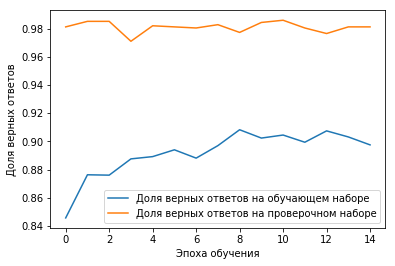

In [0]:
history.history['val_acc']

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Структура сети

In [0]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='inception.jpg')
Image('inception.jpg')

Output hidden; open in https://colab.research.google.com to view.

#Отправка решения

In [0]:
#predictions = model.predict_generator(train_gen)
#model.evaluate_generator(train_gen)
#!ls -la
#kaggle_predict(params,'cd-cnn.hdf5',True)
#!cp cd-cnn.hdf5 ./drive/'My Drive'/cd-cnn.hdf5
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .995" -f submission.csv 



100% 9.67k/9.67k [00:01<00:00, 5.30kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)


In [0]:
history

#Подбор параметров модели InceptionV3

In [0]:
!rm /content/drive/'My Drive'/best_models/*.hdf5
!rm /content/drive/'My Drive'/best_models/*.pickle

#параметры оптимизации
space = { 'batch_size' : hp.choice('batch_size', [32]), 
          'epochs': 11, 
          #'optimizer' : hp.choice('optimizer', ['nadam', 'rmsprop']), 
          'drop' : hp.choice('drop', [.45,.55]), 
          'callbacks' : True, 
          'net_class': 'InceptionV3',
          'last_block_layer_number' : 308,
          #'last_block_layer_number' : hp.choice('last_block_layer_number', [116,126]),
          #'layers' : hp.choice('layers', [1,2]),
          'layers' : 2,
          'lr' : 1e-4,
          'flatten' : False,
          #'lr' : hp.choice('lr', [1e-4, 1e-5]),
          #'flatten' : hp.choice('flatten', [True, False]),
          'units' : hp.choice('units', [128,256,512,768]), 
         
        }

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#K.set_session(session)

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=10)

print (best)
#print (trials.best_trial)

#for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
#  print(-trial['result']['loss'],space_eval_trial(space, trial))

In [0]:
!ls /content/drive/'My Drive'/best_models
#rm /content/drive/'My Drive'/best_models/*.hdf5


InceptionV30.9796748161315918.pickle	InceptionV3-cnn0.9864498376846313.hdf5
InceptionV30.9817073345184326.pickle	InceptionV3-cnn0.9871273636817932.hdf5
InceptionV30.9857723712921143.pickle	InceptionV3-cnn0.9878048896789551.hdf5
InceptionV30.9864498376846313.pickle	InceptionV3-cnn0.9884823560714722.hdf5
InceptionV30.9871273636817932.pickle	InceptionV3-cnn0.9898374080657959.hdf5
InceptionV30.9878048896789551.pickle	Xception-cnn0.9784595370292664.hdf5
InceptionV30.9884823560714722.pickle	Xception-cnn0.9791122674942017.hdf5
InceptionV30.9898374080657959.pickle	Xception-cnn0.982375979423523.hdf5
InceptionV3-cnn0.9796748161315918.hdf5	Xception-cnn0.9849869608879089.hdf5
InceptionV3-cnn0.9817073345184326.hdf5	Xception-cnn0.9875978827476501.hdf5
InceptionV3-cnn0.9857723712921143.hdf5	Xception-cnn0.9908615946769714.hdf5


In [0]:
#InceptionV30.9898374080657959.pickle  InceptionV3-cnn0.9898374080657959.hdf5
#{'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
with open('/content/drive/My Drive/best_models/InceptionV30.9898374080657959.pickle', 'rb') as f:
  params = pickle.load(f)
print(params)

{'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}


In [0]:
!ls

drive					submission.csv
InceptionV3-cnn0.9766990542411804.hdf5	test.zip
InceptionV3-cnn0.9818770289421082.hdf5	train
InceptionV3-cnn0.985760509967804.hdf5	train.zip
InceptionV3-cnn0.9896439909934998.hdf5	val
neg					Xception-cnn0.9883494973182678.hdf5
predict					Xception-cnn0.9902912378311157.hdf5
sample_data				Xception-cnn.hdf5
sample_submission.csv


In [0]:
#!nvidia-smi
for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))
  
#0.9892891645431519 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 50, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 1e-05, 'net_class': 'Xception', 'units': 512}
#0.9883154630661011 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 50, 'flatten': True, 'last_block_layer_number': 126, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 2048}
#0.9883154630661011 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 50, 'flatten': True, 'last_block_layer_number': 116, 'layers': 2, 'lr': 1e-05, 'net_class': 'Xception', 'units': 2048}
#0.9883154630661011 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 50, 'flatten': True, 'last_block_layer_number': 116, 'layers': 2, 'lr': 1e-05, 'net_class': 'Xception', 'units': 512}
#0.9873417615890503 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 50, 'flatten': True, 'last_block_layer_number': 126, 'layers': 2, 'lr': 1e-05, 'net_class': 'Xception', 'units': 1024}
#0.9853943586349487 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 50, 'flatten': False, 'last_block_layer_number': 126, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 2048}
#0.984420657157898 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 50, 'flatten': True, 'last_block_layer_number': 126, 'layers': 1, 'lr': 1e-05, 'net_class': 'Xception', 'units': 512}  


#0.9924242496490479 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1024}
#0.9914772510528564 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1024}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1536}
#0.9867424368858337 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 2, 'lr': 1e-05, 'net_class': 'Xception', 'units': 512}
#0.9857954382896423 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 126, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1536}
#0.9857954382896423 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 126, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1024}
#0.9848484992980957 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 1, 'lr': 1e-05, 'net_class': 'Xception', 'units': 512}
#0.9820075631141663 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 126, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 2048}
#0.9820075631141663 {'batch_size': 32, 'callbacks': False, 'drop': 0.4, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 126, 'layers': 1, 'lr': 1e-05, 'net_class': 'Xception', 'units': 1024}


0.9898374080657959 {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
0.9884823560714722 {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 768}
0.9878048896789551 {'batch_size': 32, 'callbacks': True, 'drop': 0.45, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
0.9871273636817932 {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
0.9871273636817932 {'batch_size': 32, 'callbacks': True, 'drop': 0.45, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'Inceptio

#Xception

In [0]:
params = {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 15, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'reglr': 0.0001, 'lr': 0.0001, 'net_class': 'Xception', 'units': 8}

if os.path.isfile('cd-cnn.hdf5'):
  os.remove('cd-cnn.hdf5')

def step_decay(epoch):
  initial_lrate = 1e-1
  drop = 0.5
  epochs_drop = 20.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay)


model = create_model(params,False)
opt = SGD(lr=1e-2, decay=0, momentum=0, nesterov=False)
#opt = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
#opt = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=15,verbose=0, mode='auto')

#тренируем 
history = model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=params['epochs'],
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            #callbacks=[сheckpoint,earlystop,lrate],
            callbacks=[сheckpoint,lrate],
            #callbacks=[сheckpoint],                              
            verbose=1)

Epoch 1/15
75/75 [==============================] - 52s 688ms/step - loss: 0.3303 - acc: 0.8706 - val_loss: 0.1026 - val_acc: 0.9662
Epoch 2/15
75/75 [==============================] - 52s 689ms/step - loss: 0.2087 - acc: 0.9316 - val_loss: 0.0665 - val_acc: 0.9812
Epoch 3/15
75/75 [==============================] - 51s 675ms/step - loss: 0.1809 - acc: 0.9332 - val_loss: 0.0436 - val_acc: 0.9867
Epoch 4/15
75/75 [==============================] - 54s 725ms/step - loss: 0.1655 - acc: 0.9412 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 5/15
75/75 [==============================] - 52s 691ms/step - loss: 0.1577 - acc: 0.9404 - val_loss: 0.0747 - val_acc: 0.9772
Epoch 6/15
75/75 [==============================] - 51s 678ms/step - loss: 0.1551 - acc: 0.9415 - val_loss: 0.0602 - val_acc: 0.9788
Epoch 7/15
75/75 [==============================] - 52s 691ms/step - loss: 0.1407 - acc: 0.9404 - val_loss: 0.0425 - val_acc: 0.9835
Epoch 8/15
75/75 [==============================] - 52s 695ms/step - 

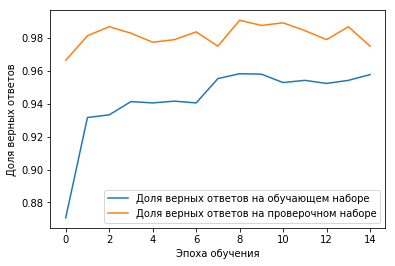

In [0]:
history.history['val_acc']

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Обучение на полном наборе данных

In [0]:
train_gen.samples

5000

In [0]:
params = {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 30, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'reglr': 0.0001, 'lr': 0.0001, 'net_class': 'Xception', 'units': 16}

if os.path.isfile('cd-cnn.hdf5'):
  os.remove('cd-cnn.hdf5')

def step_decay(epoch):
  initial_lrate = 1e-1
  drop = 0.5
  epochs_drop = 20.0
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
  return lrate    

lrate = LearningRateScheduler (step_decay)
сheckpoint = ModelCheckpoint(best_model_file_name, 
                                monitor='acc', 
                                save_best_only=True,
                                verbose=0)


model = create_model(params,False)
opt = SGD(lr=1e-2, decay=0, momentum=0, nesterov=False)
#opt = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
#opt = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


earlystop = EarlyStopping(monitor='acc', min_delta=0.001, patience=15,verbose=0, mode='auto')

#тренируем 
history = model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=params['epochs'],
            #validation_data=val_gen,
            #validation_steps=val_gen.samples // batch_size,
            #callbacks=[сheckpoint,earlystop,lrate],
            callbacks=[сheckpoint,lrate],
            #callbacks=[сheckpoint],                              
            verbose=1)

Epoch 1/30
100/100 [==============================] - 126s 1s/step - loss: 0.2308 - acc: 0.9178
Epoch 2/30
100/100 [==============================] - 59s 591ms/step - loss: 0.1390 - acc: 0.9572
Epoch 3/30
100/100 [==============================] - 66s 655ms/step - loss: 0.1206 - acc: 0.9614
Epoch 4/30
100/100 [==============================] - 66s 662ms/step - loss: 0.1087 - acc: 0.9658
Epoch 5/30
100/100 [==============================] - 67s 672ms/step - loss: 0.0963 - acc: 0.9666
Epoch 6/30
100/100 [==============================] - 66s 658ms/step - loss: 0.0866 - acc: 0.9718
Epoch 7/30
100/100 [==============================] - 65s 652ms/step - loss: 0.0878 - acc: 0.9714
Epoch 8/30
100/100 [==============================] - 64s 644ms/step - loss: 0.0753 - acc: 0.9762
Epoch 9/30
100/100 [==============================] - 67s 667ms/step - loss: 0.0653 - acc: 0.9806
Epoch 10/30
100/100 [==============================] - 67s 669ms/step - loss: 0.0669 - acc: 0.9800
Epoch 11/30
100/100 [

#Структура сети Xception

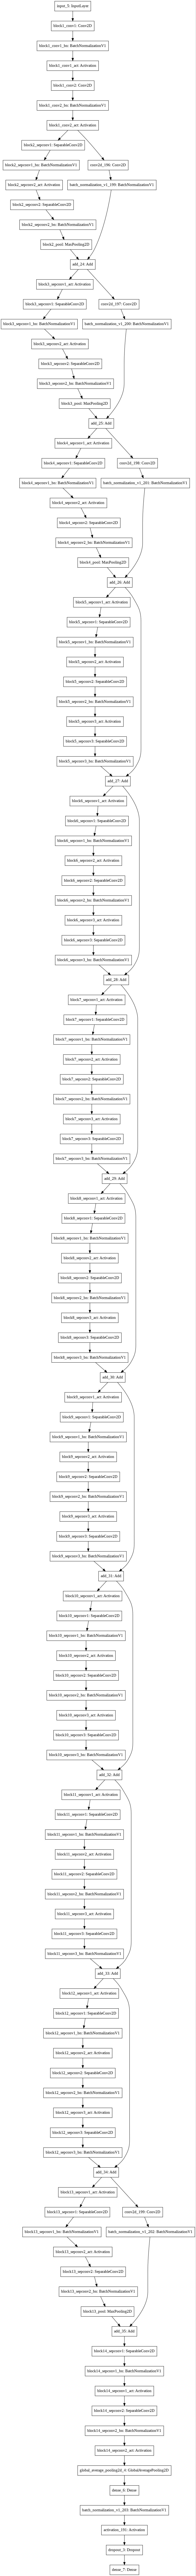

In [0]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model,to_file='xception.jpg')
Image('xception.jpg')

In [0]:
history.history['val_acc']

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Вывод

Kaggle 11 место точность на тесте 0.98900. В основе использовались сети Xception и InceptionV3, на выходе предобученной сети использовался слой GlobalAveragePooling2D, и Dense слой с 8 нейронами, увеличение нейронов в последнем слое особо не влияет на качество сети, тк в обучении данных сетей использовались классы собак и котов.



#InceptionV3 +  Xception

In [0]:
params1 = {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
params2 = {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 25, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}

opt = opt = RMSprop(lr=.0005, decay=1e-6)   

model1 = create_model(params1,False)
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    
#model1.load_weights('/content/drive/My Drive/best_models/InceptionV3-cnn0.9924026727676392.hdf5')
model1.load_weights('Iception-cnn.hdf5')

model2 = create_model(params2,False)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    
#model2.load_weights('/content/drive/My Drive/best_models/Xception-cnn0.9933523535728455.hdf5')
model2.load_weights('Xception-cnn2.hdf5')





In [0]:
#print(model1.evaluate_generator(generator=val_gen, steps = val_gen.samples // batch_size))
#print(model2.evaluate_generator(generator=val_gen, steps = val_gen.samples // batch_size))

val_gen.shuffle = True

predictions1 = model1.predict_generator(val_gen)
predictions2 = model2.predict_generator(val_gen)
y_true = val_gen.classes


y_pred1 = np.rint(predictions1).reshape(-1)
y_pred2 = np.rint(predictions2).reshape(-1)
print(accuracy_score(y_true,y_pred1))
print(accuracy_score(y_true,y_pred2))



0.9943019943019943
0.99335232668566


In [0]:
predictions = predictions1+predictions2
y_pred = []

threshold = 1

y_pred = []
for prediction in predictions:
    if prediction >= threshold:
        y_pred.append(1)
    else:
        y_pred.append(0) 
        
print(accuracy_score(y_true,y_pred))


0.9990503323836657


In [0]:
predictions1 = model1.predict_generator(test_gen, steps = test_gen.samples // batch_size)
predictions2 = model2.predict_generator(test_gen, steps = test_gen.samples // batch_size)

filenames = np.array(list(map(lambda x : x.replace('test/',''), test_gen.filenames)))

predictions = predictions1+predictions2
threshold = 1

y_pred = []
for prediction in predictions:
    if prediction >= threshold:
        y_pred.append(1)
    else:
        y_pred.append(0) 

out = np.column_stack((filenames, y_pred))
np.savetxt('submission.csv', out, header="filename,label", comments="", fmt="%s,%s")


In [0]:
import google 
google.colab.files.download('submission.csv')

In [0]:
#!cat submission.csv
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .999" -f submission.csv 
#.988

#Дальше хлам

##Индексы неправильно распознанных примеров

In [0]:
predictions = model.predict_generator(val_gen)
y_pred = np.asarray(np.rint(predictions)).reshape(-1)
y_true = val_gen.classes
idx = np.where(y_true!=y_pred)
print(accuracy_score(y_true,y_pred))
idx


0.9882429784454605


(array([ 138,  226,  356,  445,  474,  595,  712,  780,  802,  861,  944,
         977, 1012, 1066, 1173, 1358, 1402, 1434]),)

##Генератор для неправильно распознанных примеров

In [0]:
!rm -r neg
!mkdir neg
!mkdir neg/cats
!mkdir neg/dogs

for i in idx[0]:
  #print('val/'+val_gen.filenames[i],'neg/'+val_gen.filenames[i])
  shutil.copyfile('val/'+val_gen.filenames[i],'neg/'+val_gen.filenames[i])

neg_datagen = ImageDataGenerator(rescale=1. / 255 )
neg_gen = neg_datagen.flow_from_directory('neg',
                                    target_size=(img_width, img_height),
                                    batch_size=len(idx[0]),
                                    class_mode='binary')


Found 7 images belonging to 2 classes.


In [0]:
#дообучим сеть с добавлением отрицательно распознанных примеров
from tensorflow.keras.optimizers import SGD

#model = create_model(params,False)
#opt = SGD(lr=.0001, momentum=.9)        
#model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    
##model.load_weights('/content/drive/My Drive/best_models/InceptionV3-cnn0.9898374080657959.hdf5')
##model.load_weights('/content/drive/My Drive/best_models/Xception-cnn0.9911924004554749.hdf5')
#neg_datagen = ImageDataGenerator(rescale=1. / 255 )
#neg_gen = neg_datagen.flow_from_directory('neg',
#                                    target_size=(img_width, img_height),
#                                    batch_size=len(idx[0]),
#                                    class_mode='binary')

#val_gen.shuffle = False
#predictions = model.predict_generator(val_gen)
#y_pred = np.asarray(np.rint(predictions)).reshape(-1)
#y_true = val_gen.classes
#idx = np.where(y_true!=y_pred)
#print(accuracy_score(y_true,y_pred))
#idx

model = model2

val_gen.shuffle = True
#генератор добавляет отрицательные примеры
def image_generator():    
  while True:    
    batch1 = train_gen.next()
    batch2 = neg_gen.next()
    x = np.concatenate((batch1[0],batch2[0]))
    y = np.concatenate((batch1[1],batch2[1]))    
    randomize = np.arange(x.shape[0])
    np.random.shuffle(randomize)
    yield(x[randomize],y[randomize])
    #yield( np.vstack((batch1[0],batch2[0])), np.vstack((batch1[1],batch2[1])) )

def val_image_generator():    
  while True:    
    batch = val_gen.next()
    yield(batch[0],batch[1])
    
сheckpoint = ModelCheckpoint('Xception-cnn.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                verbose=0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=1e-5)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10,verbose=0, mode='auto')

batches_per_epoch = train_gen.samples // batch_size

history = model.fit(image_generator(), 
                  steps_per_epoch=(train_gen.samples+batches_per_epoch*len(idx[0])) // batch_size,
                  epochs=3,
                  validation_data=val_image_generator(),
                  validation_steps=val_gen.samples // batch_size,
                  verbose=1,
                  callbacks = [learning_rate_reduction,сheckpoint,earlystop])

Epoch 1/3
91/91 [==============================] - 75s 824ms/step - loss: 0.0276 - acc: 0.9916 - val_loss: 0.3201 - val_acc: 0.9717
Epoch 2/3
91/91 [==============================] - 68s 745ms/step - loss: 0.0252 - acc: 0.9930 - val_loss: 0.5262 - val_acc: 0.9515
Epoch 3/3
91/91 [==============================] - 69s 762ms/step - loss: 0.0177 - acc: 0.9947 - val_loss: 0.0858 - val_acc: 0.9923


In [0]:
!cp Xception-cnn.hdf5 Xception-cnn2.hdf5
!ls

drive					submission.csv
Iception-cnn.hdf5			test.zip
InceptionV3-cnn0.9876543283462524.hdf5	train
InceptionV3-cnn0.9886040091514587.hdf5	train.zip
InceptionV3-cnn0.9895536303520203.hdf5	val
InceptionV3-cnn0.9924026727676392.hdf5	Xception-cnn0.9876543283462524.hdf5
neg					Xception-cnn0.9914529919624329.hdf5
predict					Xception-cnn0.9933523535728455.hdf5
sample_data				Xception-cnn2.hdf5
sample_submission.csv			Xception-cnn.hdf5


In [0]:


#model = create_model(params)
#best_model_file_name = 'Xception-cnn.hdf5'
#model.load_weights(best_model_file_name)
#print(model.evaluate_generator(generator=val_gen, steps = val_gen.samples // batch_size))



total 499744
drwxr-xr-x 1 root root      4096 Apr 16 06:15 .
drwxr-xr-x 1 root root      4096 Apr 16 04:19 ..
drwxr-xr-x 1 root root      4096 Apr  4 20:19 .config
drwx------ 3 root root      4096 Apr 16 04:20 drive
drwxr-xr-x 4 root root      4096 Apr 16 05:47 neg
drwxr-xr-x 3 root root      4096 Apr 16 04:21 predict
drwxr-xr-x 1 root root      4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root     10906 Apr 16 04:21 sample_submission.csv
-rw-r--r-- 1 root root      9905 Apr 16 06:15 submission.csv
-rw-r--r-- 1 root root  23183907 Apr 16 04:21 test.zip
drwxr-xr-x 4 root root      4096 Nov  6 15:10 train
-rw-r--r-- 1 root root 113565182 Apr 16 04:21 train.zip
drwxr-xr-x 4 root root      4096 Apr 16 04:21 val
-rw-r--r-- 1 root root 115212456 Apr 16 04:41 Xception-cnn0.9883494973182678.hdf5
-rw-r--r-- 1 root root 115211760 Apr 16 05:17 Xception-cnn0.9902912378311157.hdf5
-rw-r--r-- 1 root root 144483888 Apr 16 06:29 Xception-cnn.hdf5


In [0]:
kaggle_predict(params,'Xception-cnn.hdf5',True)
!ls

[0.013462635611044643, 0.9954693]
drive		       submission.csv  Xception-cnn0.9883494973182678.hdf5
neg		       test.zip        Xception-cnn0.9902912378311157.hdf5
predict		       train	       Xception-cnn.hdf5
sample_data	       train.zip
sample_submission.csv  val


In [0]:
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .9955" -f submission.csv  

100% 9.67k/9.67k [00:02<00:00, 4.78kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)


In [0]:
#параметры оптимизации
space = { 'batch_size' : hp.choice('batch_size', [32]), 
          'epochs': 10, 
          #'optimizer' : hp.choice('optimizer', ['nadam', 'rmsprop']), 
          'drop' : hp.choice('drop', [.35,.45,.55]), 
          'callbacks' : False, 
          'net_class': 'Xception',
          'last_block_layer_number' : 308,
          #'last_block_layer_number' : hp.choice('last_block_layer_number', [116,126]),
          #'layers' : hp.choice('layers', [1,2]),
          'layers' : 2,
          'lr' : 1e-4,
          'flatten' : False,
          #'lr' : hp.choice('lr', [1e-4, 1e-5]),
          #'flatten' : hp.choice('flatten', [True, False]),
          'units' : hp.choice('units', [128,256,512,768]), 
         
        }

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#K.set_session(session)

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=15)

print (best)
#print (trials.best_trial)

#for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
#  print(-trial['result']['loss'],space_eval_trial(space, trial))

In [0]:

for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))

#0.9933711886405945 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9933711886405945 {'batch_size': 32, 'callbacks': False, 'drop': 0.45, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9914772510528564 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9905303120613098 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1024}
#0.9905303120613098 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9905303120613098 {'batch_size': 32, 'callbacks': False, 'drop': 0.45, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9905303120613098 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9905303120613098 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 1024}
#0.9895833134651184 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9895833134651184 {'batch_size': 32, 'callbacks': False, 'drop': 0.45, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 768}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.35, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9886363744735718 {'batch_size': 32, 'callbacks': False, 'drop': 0.45, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 512}
#0.9867424368858337 {'batch_size': 32, 'callbacks': False, 'drop': 0.45, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 2, 'lr': 0.0001, 'net_class': 'Xception', 'units': 768}

In [0]:
#параметры оптимизации
'''
space = { 'batch_size' : hp.choice('batch_size', [32]), 
          'epochs': 10, 
          #'optimizer' : hp.choice('optimizer', ['nadam', 'rmsprop']), 
          'drop' : hp.choice('drop', [.5,.55,.6,.65]), 
          'callbacks' : False, 
          'net_class': 'Xception',
          'last_block_layer_number' : 116,
          #'last_block_layer_number' : hp.choice('last_block_layer_number', [116,126]),
          'layers' : 1,
          #'layers' : hp.choice('layers', [1,2]),
          'lr' : 1e-4,
          'flatten' : False,
          #'lr' : hp.choice('lr', [1e-4, 1e-5]),
          #'flatten' : hp.choice('flatten', [True, False]),
          'units' : hp.choice('units', [128,160,192,256]), 
         
        }
'''
space = { 'batch_size' : hp.choice('batch_size', [32]), 
          'epochs': 10, 
          #'optimizer' : hp.choice('optimizer', ['nadam', 'rmsprop']), 
          'drop' : hp.choice('drop', [.5,.6]), 
          'callbacks' : False, 
          'net_class': 'Xception',
          'last_block_layer_number' : hp.choice('last_block_layer_number', [116,126]),
          'layers' : hp.choice('layers', [1,2]),
          'lr' : hp.choice('lr', [1e-4, 1e-5]),
          'flatten' : hp.choice('flatten', [True, False]),
          'units' : hp.choice('units', [96,128,256,512]), 
         
        }

#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#K.set_session(session)

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=15)

print (best)
#print (trials.best_trial)

#for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
#  print(-trial['result']['loss'],space_eval_trial(space, trial))

In [0]:
for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))

#0.9898504018783569 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
#0.9893162250518799 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9893162250518799 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9887820482254028 {'batch_size': 32, 'callbacks': False, 'drop': 0.65, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
#0.9887820482254028 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#0.9887820482254028 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
#0.9887820482254028 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 192}
#0.9882478713989258 {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
#0.9877136945724487 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
#0.9871794581413269 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 160}  

0.9922330379486084 {'batch_size': 32, 'callbacks': False, 'drop': 0.5, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 1, 'lr': 1e-05, 'net_class': 'Xception', 'units': 128}
0.9922330379486084 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 2, 'lr': 1e-05, 'net_class': 'Xception', 'units': 96}
0.9915857315063477 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 126, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
0.9909384846687317 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': True, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
0.9909384846687317 {'batch_size': 32, 'callbacks': False, 'drop': 0.6, 'epochs': 10, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}
0

In [0]:
from tensorflow.keras.optimizers import SGD
#params = {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 50, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#{'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 11, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}
#params = {'batch_size': 32, 'callbacks': False, 'drop': 0.55, 'epochs': 20, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 256}
#params = {'batch_size': 32, 'callbacks': True, 'drop': 0.55, 'epochs': 30, 'flatten': False, 'last_block_layer_number': 308, 'layers': 2, 'lr': 0.0001, 'net_class': 'InceptionV3', 'units': 512}

batch_size = params['batch_size']
best_model_file_name = params['net_class']+'-cnn.hdf5'


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                            patience=4, 
                            verbose=0, 
                            factor=0.5, 
                            min_lr=1e-5)

сheckpoint = ModelCheckpoint(best_model_file_name, 
                            monitor='val_acc', 
                            save_best_only=True,
                            verbose=0)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10,verbose=0, mode='auto')

for i in range(5):
  np.random.seed(random.randint(1,999999))
  random.seed(random.randint(1,999999))

  #создаем модель
  model = create_model(params, False)
  #opt = SGD(lr=.0005, momentum=.9)        
  opt = RMSprop(lr=.0005, decay=1e-6)   
  #opt = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


  #тренируем 
  history = model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=params['epochs'],
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            callbacks=[сheckpoint,learning_rate_reduction,earlystop],
            verbose=1)

  if os.path.isfile(best_model_file_name):
    os.rename(best_model_file_name, "{}-cnn{}.hdf5".format(params['net_class'],np.max(history.history['val_acc'])))

Epoch 1/30
49/49 [==============================] - 347s 7s/step - loss: 0.4796 - acc: 0.7740 - val_loss: 0.0839 - val_acc: 0.9687
Epoch 2/30
49/49 [==============================] - 29s 589ms/step - loss: 0.3087 - acc: 0.8651 - val_loss: 0.1298 - val_acc: 0.9487
Epoch 3/30
49/49 [==============================] - 34s 689ms/step - loss: 0.2236 - acc: 0.9077 - val_loss: 0.0883 - val_acc: 0.9810
Epoch 4/30
49/49 [==============================] - 31s 638ms/step - loss: 0.2069 - acc: 0.9143 - val_loss: 0.0618 - val_acc: 0.9791
Epoch 5/30
49/49 [==============================] - 35s 704ms/step - loss: 0.1984 - acc: 0.9201 - val_loss: 0.0383 - val_acc: 0.9867
Epoch 6/30
49/49 [==============================] - 31s 633ms/step - loss: 0.1825 - acc: 0.9280 - val_loss: 0.0833 - val_acc: 0.9858
Epoch 7/30
49/49 [==============================] - 33s 664ms/step - loss: 0.1835 - acc: 0.9205 - val_loss: 0.0709 - val_acc: 0.9896
Epoch 8/30
49/49 [==============================] - 32s 659ms/step - lo

KeyboardInterrupt: ignored

In [0]:
#!ls
#!cp Xception-cnn0.9933523535728455.hdf5 /content/drive/'My Drive'/best_models/Xception-cnn0.9933523535728455.hdf5
!cp InceptionV3-cnn0.9924026727676392.hdf5 /content/drive/'My Drive'/best_models/InceptionV3-cnn0.9924026727676392.hdf5
!ls /content/drive/'My Drive'/best_models

InceptionV30.9796748161315918.pickle	InceptionV3-cnn0.9871273636817932.hdf5
InceptionV30.9817073345184326.pickle	InceptionV3-cnn0.9878048896789551.hdf5
InceptionV30.9857723712921143.pickle	InceptionV3-cnn0.9884823560714722.hdf5
InceptionV30.9864498376846313.pickle	InceptionV3-cnn0.9898374080657959.hdf5
InceptionV30.9871273636817932.pickle	InceptionV3-cnn0.9924026727676392.hdf5
InceptionV30.9878048896789551.pickle	Xception-cnn0.9784595370292664.hdf5
InceptionV30.9884823560714722.pickle	Xception-cnn0.9791122674942017.hdf5
InceptionV30.9898374080657959.pickle	Xception-cnn0.982375979423523.hdf5
InceptionV3-cnn0.9796748161315918.hdf5	Xception-cnn0.9849869608879089.hdf5
InceptionV3-cnn0.9817073345184326.hdf5	Xception-cnn0.9875978827476501.hdf5
InceptionV3-cnn0.9857723712921143.hdf5	Xception-cnn0.9908615946769714.hdf5
InceptionV3-cnn0.9864498376846313.hdf5	Xception-cnn0.9933523535728455.hdf5


In [0]:
!mv Xception-cnn.hdf5 Xception-cnn41.hdf5
!ls -la
#random.randint(1,999999)



#Prediction

In [0]:
!mkdir predict
!mv test predict

#params = {'batch_size': 32, 'callbacks': True, 'drop': 0.6, 'epochs': 25, 'flatten': False, 'last_block_layer_number': 116, 'layers': 1, 'lr': 0.0001, 'net_class': 'Xception', 'units': 128}


# Каталог с данными для распознавания
test_dir = 'predict'
# Количество элементов данных для распознавания
nb_test_samples = 1000

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')


test_generator.reset()

model = create_model(params)

#best_model_file_name = 'Xception-cnn41.hdf5'
best_model_file_name = 'Xception-cnn0.9935275316238403.hdf5'

model.load_weights(best_model_file_name)

print(model.evaluate_generator(generator=val_gen, steps = nb_test_samples // batch_size))

predictions = model.predict_generator(test_generator, steps = nb_test_samples // batch_size)

filenames = []
for filename in test_generator.filenames:
    filenames.append(filename.replace('test/',''))
filenames[:5]

threshold = .5

binary_predictions = []
for prediction in predictions:
    if prediction >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 


'''
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
Finally, save the results to a CSV file.

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)
'''        
        
        
out = np.column_stack((filenames, binary_predictions))
np.savetxt('submission.csv', out, header="filename,label", 
            comments="", fmt="%s,%s")

#!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .9912" -f submission.csv

Found 1000 images belonging to 1 classes.
[0.03491133290677978, 0.99352753]


In [0]:
kaggle_predict(params,best_model_file_name)

{'cats': 0, 'dogs': 1}

In [0]:
#!cat submission.csv
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .994" -f submission.csv

100% 9.67k/9.67k [00:10<00:00, 965B/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)


In [0]:
!ls

drive	     sample_submission.csv  train      Xception-cnn02.hdf5
predict      submission.csv	    train.zip  Xception-cnn12.hdf5
sample_data  test.zip		    val        Xception-cnn41.hdf5


#Xception

In [0]:
%%time 

xception = Xception(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
xception.trainable = False

model = Sequential()
# Добавляем в модель сеть Xception вместо слоя
model.add(xception)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,
    verbose=1)

97.28

In [0]:


transformation_ratio = .05

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=transformation_ratio,
                                   shear_range=transformation_ratio,
                                   zoom_range=transformation_ratio,
                                   cval=transformation_ratio,
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                    target_size=(img_width, img_height),
                                    batch_size=batch_size,
                                    class_mode='binary')

val_gen = val_datagen.flow_from_directory(val_dir,
                                    target_size=(img_width, img_height),
                                    batch_size=batch_size,
                                    class_mode='binary')

base_model = Xception(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# add your top layer block to your base model
model = Model(base_model.input, predictions)

#замораживаем веса
for layer in base_model.layers:
  layer.trainable = False
#xception.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model.fit_generator(train_gen,
            steps_per_epoch=train_gen.samples // batch_size,
            epochs=10,
            validation_data=val_gen,
            validation_steps=val_gen.samples // batch_size,
            verbose=1)



#Визуализация модели Xception

In [0]:
base_model.summary()
print(len(base_model.layers))
i = 1
for layer in base_model.layers:  
  print(i,layer.name)
  i += 1


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Found 4002 images belonging to 2 classes.
Found 998 images belonging to 2 classes.


In [0]:

#GlobalAveragePooling2D
#last_block_layer_number = 126 Dense(256)  0.9719 
#last_block_layer_number = 116 Dense(768)  0.9869
#last_block_layer_number = 106 Dense(1024)  0.9869
#last_block_layer_number = 116 Dense(1024)  0.9869
#last_block_layer_number = 126 Dense(1024)  0.9828

#flatten
#0.9899
#второй x = Dropout(0.3)(x) #0.9869

batch_size = 48
#best_model_file_name, history = fine_tune('Xception', last_block_layer_number)
#best_model_file_name, history = fine_tune(net_class='Xception', flatten=True, units=2048, drop=.5, last_block_layer_number=116) #0.9877676
best_model_file_name, history = fine_tune(net_class='Xception', flatten=True, units=2048, drop=.5, last_block_layer_number=117) #0.
#best_model_file_name, history = fine_tune(net_class='Xception', flatten=True, units=2048, drop=.5, last_block_layer_number=126) #0.
print(np.max(history.history['val_acc']))




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
81/81 [==============================] - 120s 1s/step - loss: 0.1989 - acc: 0.9263 - val_loss: 0.0649 - val_acc: 0.9857
Epoch 2/50
81/81 [==============================] - 86s 1s/step - loss: 0.0819 - acc: 0.9716 - val_loss: 0.1842 - val_acc: 0.9735
Epoch 3/50
81/81 [==============================] - 87s 1s/step - loss: 0.0523 - acc: 0.9789 - val_loss: 0.0875 - val_acc: 0.9817
Epoch 4/50
81/81 [==============================] - 105s 1s/step - loss: 0.0457 - acc: 0.9848 - val_loss: 0.0489 - val_acc: 0.9867
Epoch 5/50
81/81 [==============================] - 104s 1s/step - loss: 0.0326 - acc: 0.9883 - val_loss: 0.0407 - val_acc: 0.9908
Epoch 6/50
81/81 [==============================] - 86s 1s/step - loss: 0.0286 - acc: 0.9908 - val_loss: 0.0574 

In [0]:
best_model_file_name, history = fine_tune(net_class='Xception', flatten=True, units=2048, drop=.5, last_block_layer_number=116) #0..9918
print(np.max(history.history['val_acc']))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
81/81 [==============================] - 118s 1s/step - loss: 0.2473 - acc: 0.9132 - val_loss: 0.1132 - val_acc: 0.9796
Epoch 2/50
81/81 [==============================] - 104s 1s/step - loss: 0.0772 - acc: 0.9657 - val_loss: 0.0831 - val_acc: 0.9837
Epoch 3/50
81/81 [==============================] - 105s 1s/step - loss: 0.0556 - acc: 0.9808 - val_loss: 0.0703 - val_acc: 0.9867
Epoch 4/50
81/81 [==============================] - 86s 1s/step - loss: 0.0470 - acc: 0.9843 - val_loss: 0.0710 - val_acc: 0.9857
Epoch 5/50
81/81 [==============================] - 87s 1s/step - loss: 0.0270 - acc: 0.9886 - val_loss: 0.1071 - val_acc: 0.9837
Epoch 6/50
81/81 [==============================] - 87s 1s/step - loss: 0.0275 - acc: 0.9903 - val_loss: 0.0873 

In [0]:
!mkdir predict
!mv test predict

# Каталог с данными для распознавания
test_dir = 'predict'
# Количество элементов данных для распознавания
nb_test_samples = 1000

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')


test_generator.reset()

model = create_model(net_class='Xception', flatten=True, units=2048, drop=.5, comp = True)

model.load_weights(best_model_file_name)
predictions = model.predict_generator(test_generator, steps = nb_test_samples // batch_size)

filenames = []
for filename in test_generator.filenames:
    filenames.append(filename.replace('test/',''))
filenames[:5]

threshold = .5

binary_predictions = []
for prediction in predictions:
    if prediction >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 


out = np.column_stack((filenames, binary_predictions))
np.savetxt('submission.csv', out, header="filename,label", 
            comments="", fmt="%s,%s")

#!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .9916" -f submission.csv


mkdir: cannot create directory ‘predict’: File exists
mv: cannot stat 'test': No such file or directory
Found 1000 images belonging to 1 classes.


In [0]:
!head submission.csv
#!ls predict/test
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab .9918" -f submission.csv

filename,label
0.jpg,0
1.jpg,1
10.jpg,1
100.jpg,1
101.jpg,1
102.jpg,0
103.jpg,0
104.jpg,1
105.jpg,0
100% 9.67k/9.67k [00:01<00:00, 5.30kB/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/cli.py", line 64, in main
    print(out, end='')
UnicodeEncodeError: 'latin-1' codec can't encode characters in position 26-38: ordinal not in range(256)


In [0]:
base_model = ResNet50(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

base_model.summary()
print(len(base_model.layers))
i = 1
for layer in base_model.layers:  
  print(i,layer.name)
  i += 1


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

In [0]:
best_model_file_name, history = fine_tune(net_class='ResNet50', flatten=True, units=512, drop=.5, lr =1e-5, last_block_layer_number=164 ) 
print(np.max(history.history['val_acc']))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/50
81/81 [==============================] - 143s 2s/step - loss: 0.2933 - acc: 0.8674 - val_loss: 1.0395 - val_acc: 0.4893
Epoch 2/50
81/81 [==============================] - 72s 893ms/step - loss: 0.1344 - acc: 0.9465 - val_loss: 1.1517 - val_acc: 0.4893
Epoch 3/50
81/81 [==============================] - 75s 931ms/step - loss: 0.1129 - acc: 0.9545 - val_loss: 1.1125 - val_acc: 0.4893
Epoch 4/50
81/81 [==============================] - 75s 930ms/step - loss: 0.0924 - acc: 0.9669 - val_loss: 1.1924 - val_acc: 0.4893
Epoch 5/50
81/81 [==============================] - 75s 928ms/step - loss: 0.0746 - acc: 0.9716 - val_loss: 1.2570 - val_acc: 0.4893
Epoch 6/50
81/81 [==============================] - 75s 932ms/step - loss: 0.0628 - acc: 0.9736 - val_loss: 1.3762 - val_acc: 0.4893
Epoch 7/50
81/81 [==============================] - 76s 933ms/step - loss: 0.0585 - acc: 0.9766 - val_loss: 1.4145 - val_acc: 0.4893
Epoch 8/50
81/81 [==============================] - 75s 932ms/step - lo

KeyboardInterrupt: ignored

#IceptionV3

In [0]:
%%time 

iceptionV3 = InceptionV3(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
iceptionV3.trainable = False

model = Sequential()
# Добавляем в модель сеть InceptionV3 вместо слоя
model.add(iceptionV3)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    verbose=1)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/10
100/100 [==============================] - 79s 792ms/step - loss: 0.3786 - acc: 0.8274
Epoch 2/10
100/100 [==============================] - 82s 820ms/step - loss: 0.2298 - acc: 0.9024
Epoch 3/10
100/100 [==============================] - 82s 819ms/step - loss: 0.1977 - acc: 0.9232
Epoch 4/10
100/100 [==============================] - 82s 822ms/step - loss: 0.1832 - acc: 0.9244
Epoch 5/10
100/100 [==============================] - 81s 811ms/step - loss: 0.1659 - acc: 0.9312
Epoch 6/10
100/100 [==============================] - 82s 819ms/step - loss: 0.1538 - acc: 0.9350
Epoch 7/10
100/100 [==============================] - 82s 819ms/step - loss: 0.1627 - acc: 0.9314
Epoch 8/10
100/100 [==============================] - 82s 820ms/step - loss: 0.1472 - acc: 0.9392
Epoch 9/10
100/100 [==============================] - 82s 817ms/step - loss: 0.1432 - acc: 0.9402
Epoch 10/10
100/100 [==============================] 

#ResNet50

In [0]:
%%time 

resNet50 = ResNet50(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
resNet50.trainable = False

last_block_layer_number = 154
for layer in resNet50.layers[:last_block_layer_number]:
    layer.trainable = False
for layer in resNet50.layers[last_block_layer_number:]:
    layer.trainable = True

model = Sequential()
# Добавляем в модель сеть ResNet50 вместо слоя
model.add(resNet50)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

#history  = model.fit_generator(
#    train_generator,
#    steps_per_epoch=nb_train_samples // batch_size,
#    epochs=10,
#    verbose=1)

history = model.fit_generator(train_gen,
          steps_per_epoch=train_gen.samples // batch_size,
          epochs=50,
          validation_data=val_gen,
          validation_steps=val_gen.samples // batch_size,
          callbacks=[сheckpoint,learning_rate_reduction,earlystop],
          verbose=1)


print(np.max(history.history['val_acc']))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
81/81 [==============================] - 84s 1s/step - loss: 0.3783 - acc: 0.8453 - val_loss: 0.7563 - val_acc: 0.5170
Epoch 2/50
81/81 [==============================] - 71s 872ms/step - loss: 0.1791 - acc: 0.9338 - val_loss: 0.8221 - val_acc: 0.5170
Epoch 3/50
81/81 [==============================] - 73s 898ms/step - loss: 0.1340 - acc: 0.9475 - val_loss: 1.0476 - val_acc: 0.5170
Epoch 4/50
81/81 [==============================] - 73s 899ms/step - loss: 0.1128 - acc: 0.9568 - val_loss: 1.0065 - val_acc: 0.5170
Epoch 5/50
81/81 [==============================] - 73s 900ms/step - loss: 0.1003 - acc: 0.9618 - val_loss: 1.0449 - val_acc: 0.5170
Epoch 6/50
81/81 [==============================] - 73s 897ms/step - loss: 0.1074 - acc: 0.9620 - val_loss: 1.

#NASNetLarge

In [0]:
#%%time 

import tensorflow.keras.backend as K
#K.set_image_data_format('channels_first')

nasNetLarge  = NASNetLarge(weights='imagenet',                   
                  include_top=False)
                  #input_shape=(224,224,3))

#from tensorflow.keras.applications.nasnet import NASNetLarge


#замораживаем веса
nasNetLarge.trainable = False

model = Sequential()
# Добавляем в модель сеть NASNetLarge вместо слоя
model.add(ZeroPadding2D(padding=(107,107)))
model.add(nasNetLarge)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    verbose=1)

#K.set_image_data_format('channels_last')


Instructions for updating:
Colocations handled automatically by placer.
343613440/343610240 [==============================] - 5s 0us/step


AttributeError: ignored

## Создаем составную нейронную сеть на основе VGG16


In [0]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

#замораживаем веса
vgg16_net.trainable = False

model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 89s 890ms/step - loss: 0.6311 - acc: 0.6420
Epoch 2/10
100/100 [==============================] - 88s 876ms/step - loss: 0.4637 - acc: 0.7874
Epoch 3/10
100/100 [==============================] - 87s 874ms/step - loss: 0.3929 - acc: 0.8316
Epoch 4/10
100/100 [==============================] - 87s 875ms/step - loss: 0.3529 - acc: 0.8484
Epoch 5/10
100/100 [==============================] - 87s 873ms/step - loss: 0.3260 - acc: 0.8608
Epoch 6/10
100/100 [==============================] - 88s 879ms/step - loss: 0.3068 - acc: 0.8700
Epoch 7/10
100/100 [==============================] - 88s 879ms/step - loss: 0.2846 - acc: 0.8860
Epoch 8/10
100/100 [==============================] - 88s 879ms/step - loss: 0.2794 - acc: 0.8822
Epoch 9/10
100/100 [==============================] - 88s 879ms/step - loss: 0.2687 - acc: 0.8914
Epoch 10/10
100/100 [==============================] - 88s 879ms/step 